In [1]:
!pip install darts==0.23.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install darts==0.23.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [54]:
%pip install pmdarima
!pip install darts
import time
t_start1 = time.perf_counter()


%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    TCNModel
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.dataprocessing.transformers import Scaler


from darts.datasets import AirPassengersDataset


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

TRAIN = dt.datetime(1957,5,1).date()            # training until date AirPassengers
# TRAIN = "20051201"                            # training until date AusBeer
# TRAIN = 1600                                  # training until index HeartRate (if float, then interpret as % split)
# TRAIN = dt.datetime(1966,3,1).date()          # training MonthlyMilk or Sunspots


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
## load data

ts = AirPassengersDataset().load()


series = ts       #["heater"]
df = ts.pd_dataframe()
df.head()


component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [5]:
df.describe()

component,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
# replace 0 and NaN by backfilling
df.fillna(method='bfill', inplace=True)
df.describe

<bound method NDFrame.describe of component   #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
...                 ...
1960-08-01        606.0
1960-09-01        508.0
1960-10-01        461.0
1960-11-01        390.0
1960-12-01        432.0

[144 rows x 1 columns]>

In [7]:
nan_count = df['#Passengers'].isna().sum()
print(nan_count)


0


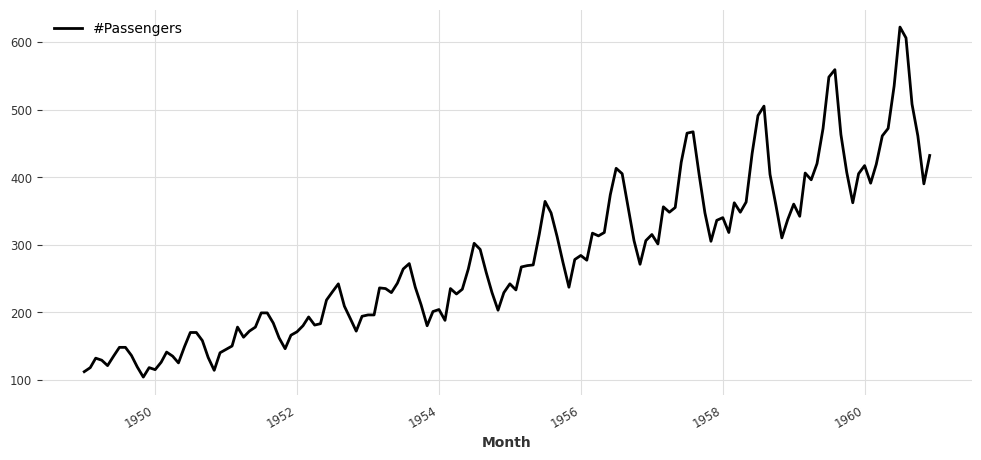

In [8]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [9]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 12.


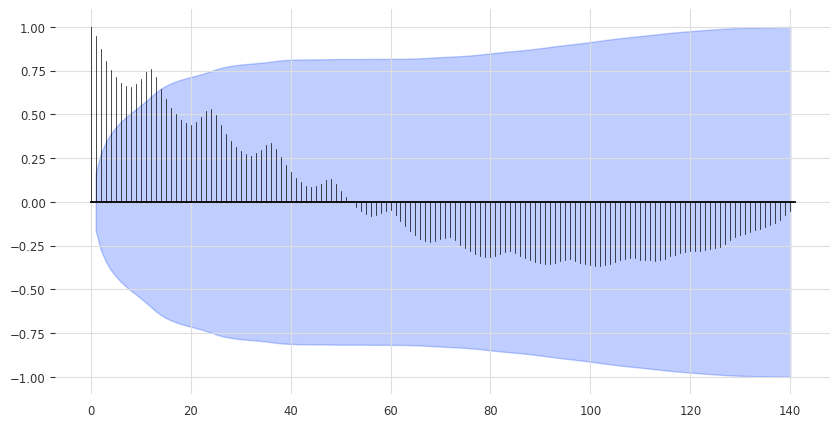

In [13]:
plot_acf(ts,max_lag=140)

In [29]:
EPOCH = 300    
FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = "19580801"   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001

In [30]:
# split training vs validation datasets
train2, val2 = ts.split_after(pd.Timestamp(FC_START))

In [37]:
# normalize the time series
trf = Scaler()
train2_trf = trf.fit_transform(train2)
val2_trf = trf.transform(val2)
ts_trf = trf.transform(ts)

In [41]:
# derive the month from the date strings
month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)

scaler_month = Scaler()
covariates = scaler_month.fit_transform(month_series)

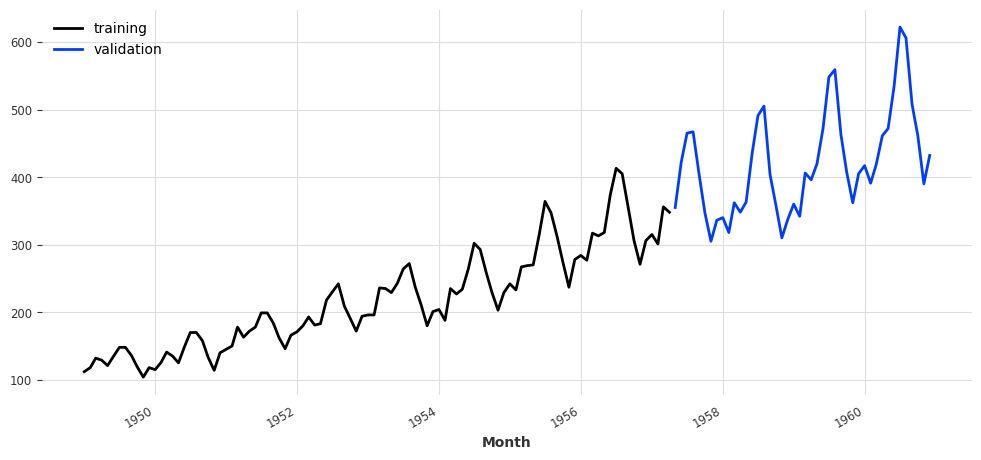

In [14]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
train, val = series.split_before(split_at)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [15]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [63]:
m_TCN=TCNModel(
        input_chunk_length=13,
        output_chunk_length=12, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},

        force_reset=True,
        random_state=42)



    



In [16]:
# prepare Naive forecaster

m_naive = NaiveDrift()

In [17]:
# prepare Exponential Smoothing forecaster

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
    

In [18]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

In [20]:
# prepare ARIMA forecaster

y = np.asarray(series.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")
    

In [21]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100


In [65]:
# laundry list of forecasters to run

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet,
    m_TCN]

In [66]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.10073458170518279sec
beginning: Theta(-3.1515151515151505)
completed: Theta(-3.1515151515151505):0.04705857625231147sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=654.738, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=653.262, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=651.601, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=652.131, Time=0.71 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=650.926, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=651.998, Time=0.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=656.051, Time=1.00 sec
 ARIMA(2,1,0)(0,1,0)[12]             : BIC=655.261, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]       

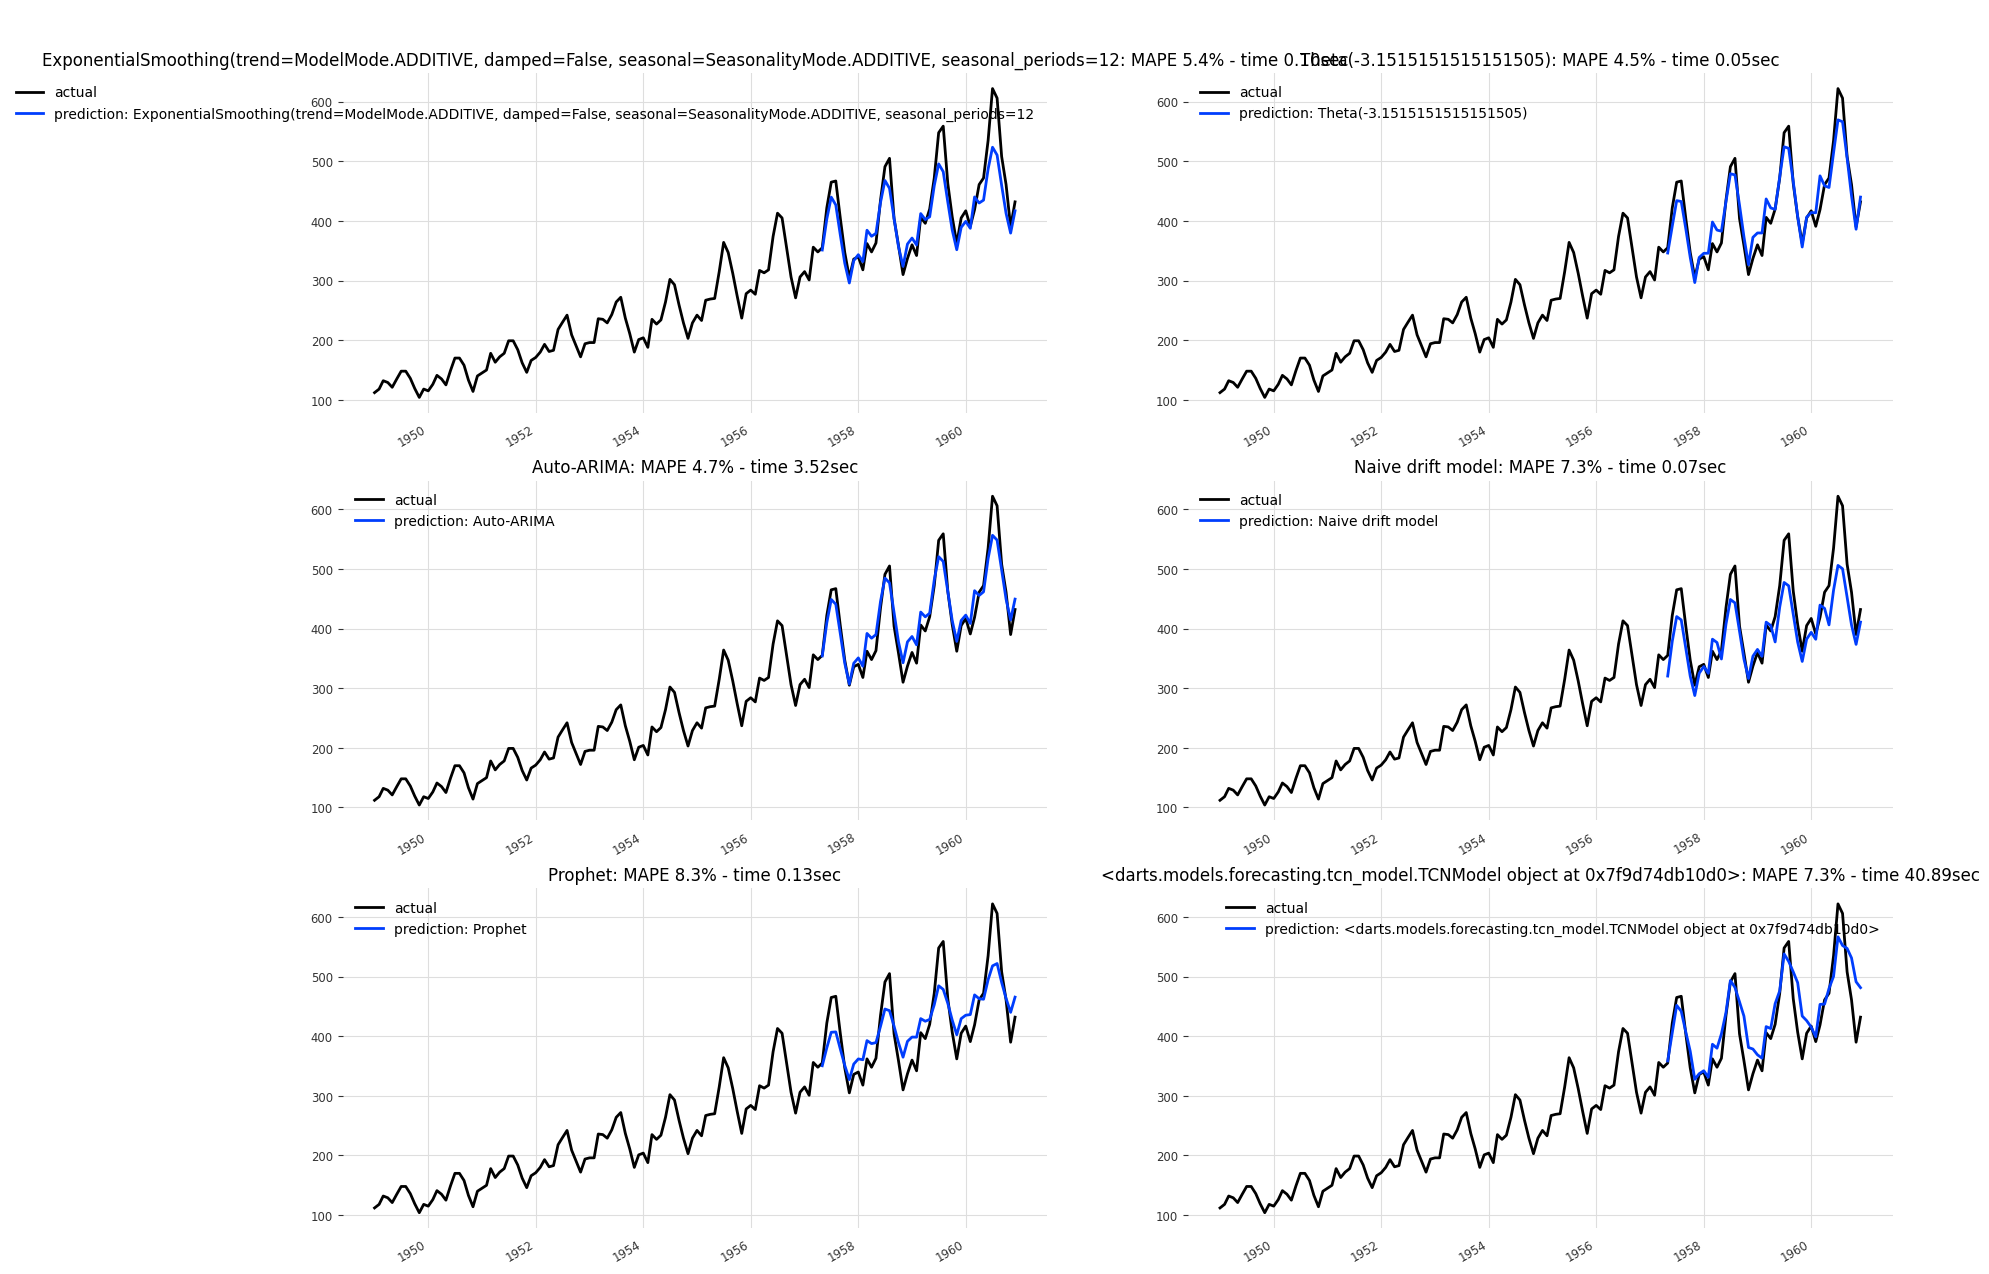

In [67]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()


In [68]:
act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]




Ljung-Box test for white-noise residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 : 4.1524293719867895e-07
Theta(-3.1515151515151505) : 1.4473990663732929e-05
Auto-ARIMA : 1.628237103629946e-05
Naive drift model : 9.379930722128987e-08
Prophet : 1.071259173154926e-08
<darts.models.forecasting.tcn_model.TCNModel object at 0x7f9d74db10d0> : 6.916359610006738e-05

test for normality of residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 : 0.018678575542425833
Theta(-3.1515151515151505) : 0.905256966439788
Auto-ARIMA : 0.042532562370373575
Naive drift model : 0.17096643152873148
Prophet : 0.10384780548828768
<darts.models.forecasting.tcn_model.TCNModel object at 0x7f9d74db10d0> : 0.8343849145273509


[None, None, None, None, None, None]

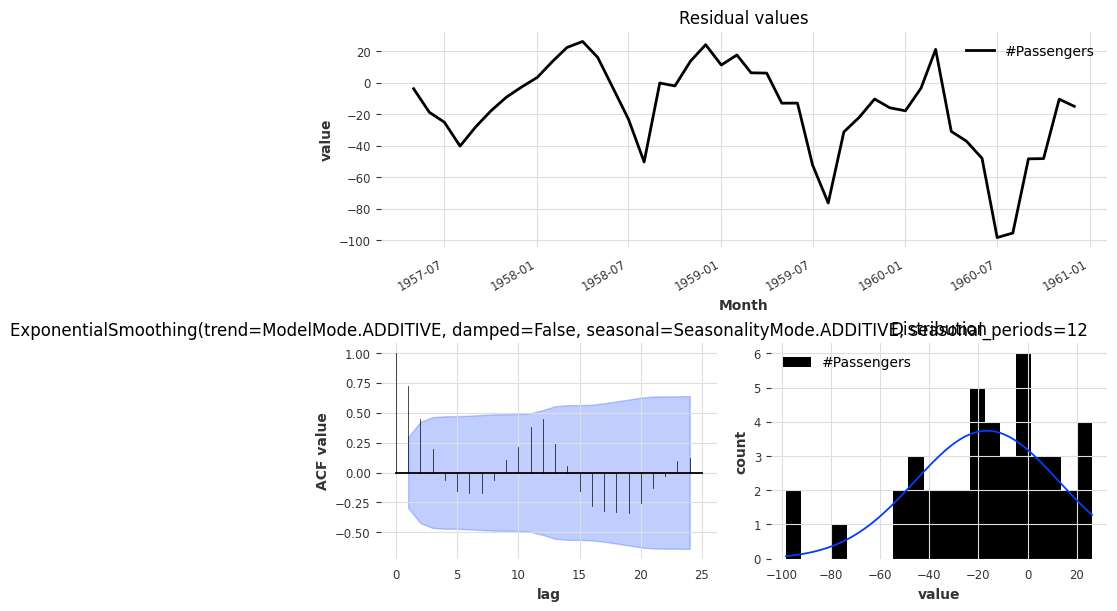

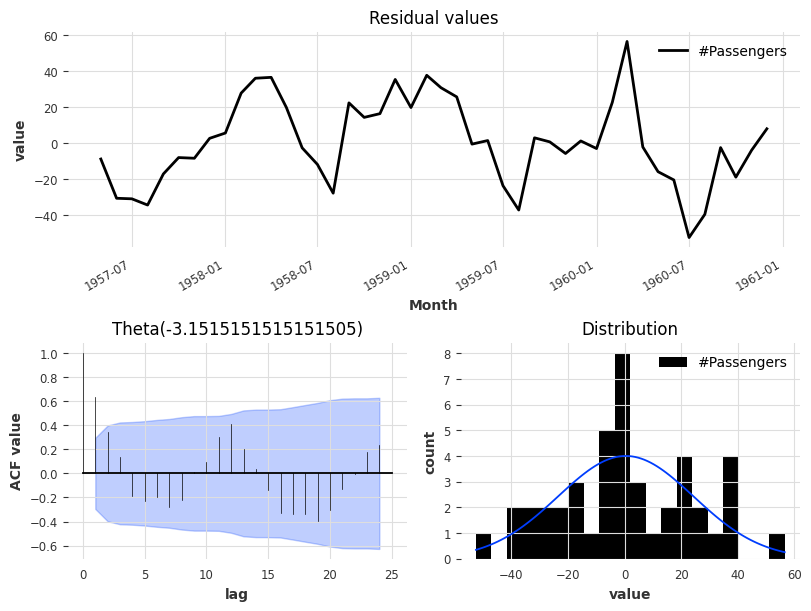

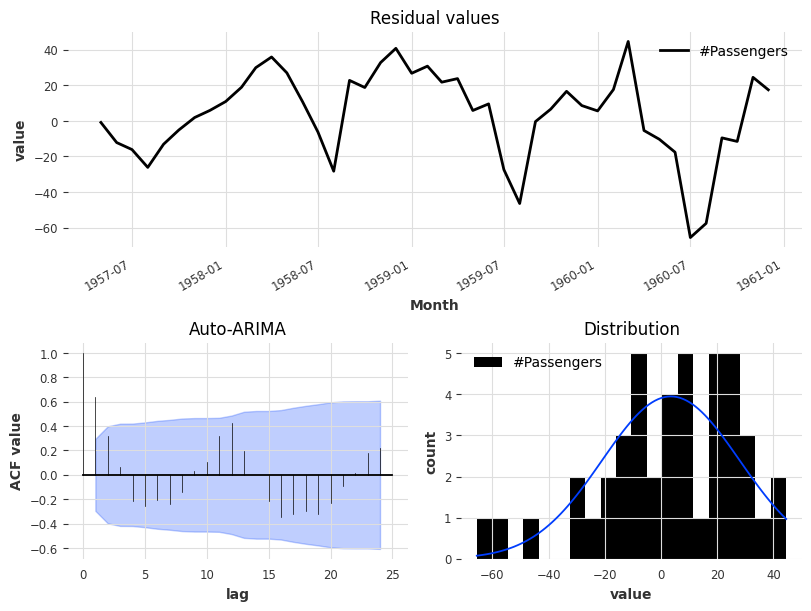

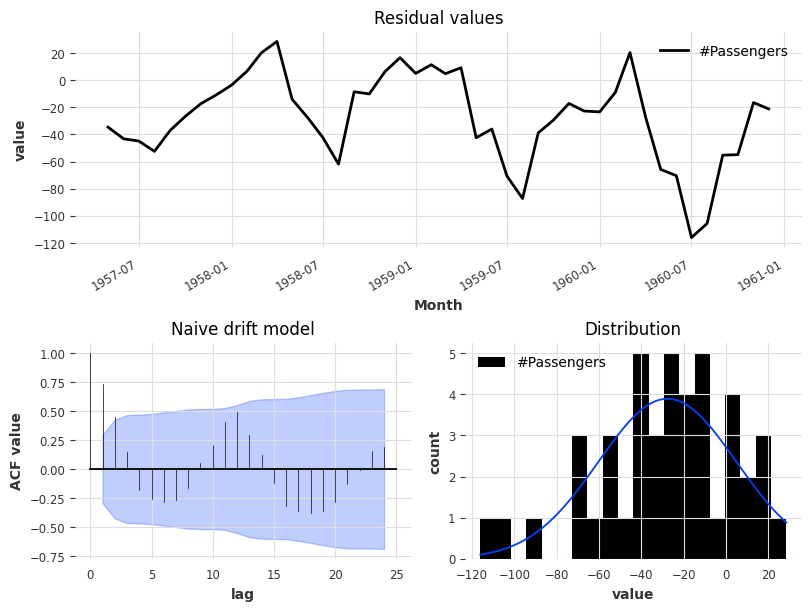

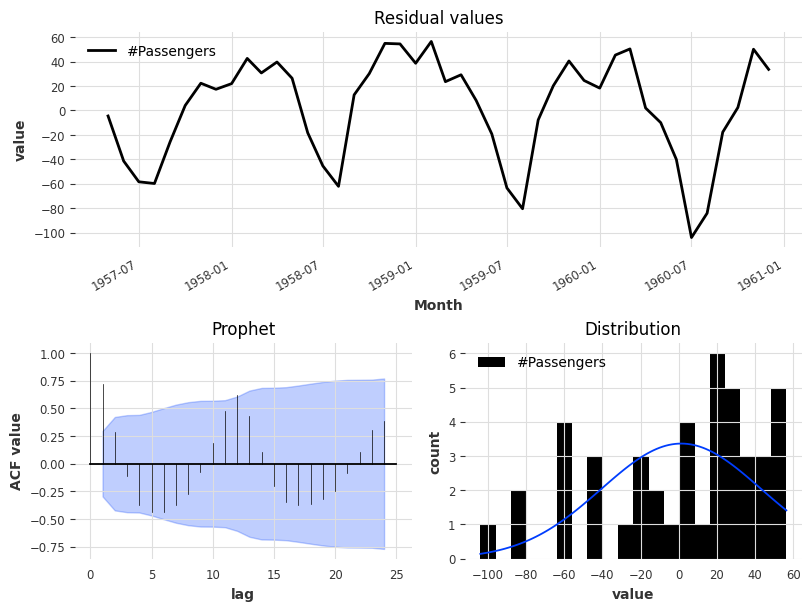

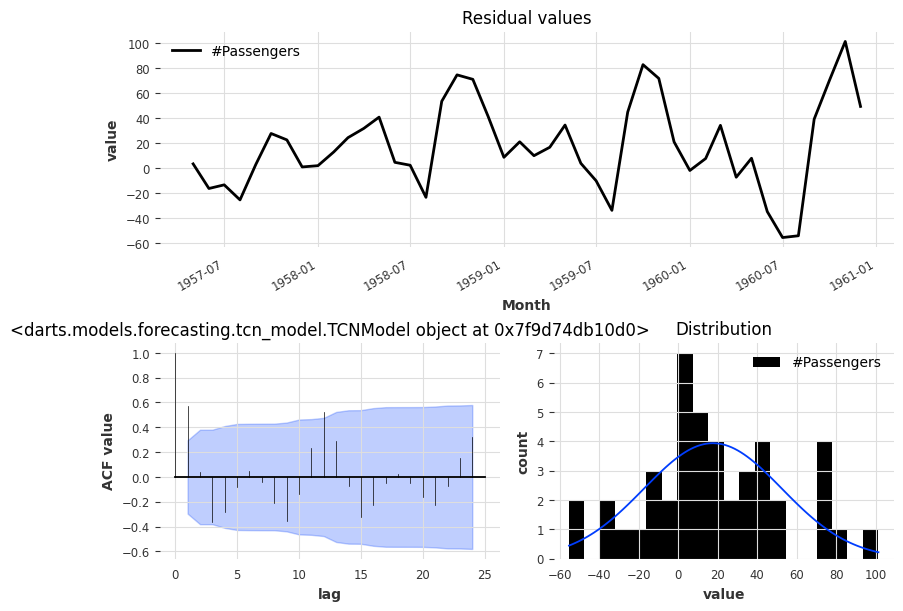

In [69]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act

        

        plot_residuals_analysis(resid);
        plt.title(str(m))
        

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1d46018-1c24-449a-948c-0edaf6e96822' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>